In [1]:
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
X_val = X_train_full[-10_000:]
y_val = y_train_full[-10_000:]
X_train = X_train_full[:-10_000]
y_train = y_train_full[:-10_000]

In [4]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

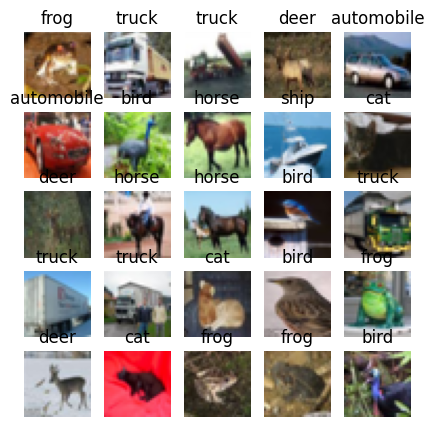

In [5]:
class_names = ['airplane', 'automobile', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(5,5))

for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(X_train[i])
  plt.title(f"{class_names[y_train[i][0]]}")
  plt.axis("off")

In [6]:
from functools import partial

Conv = partial(tf.keras.layers.Conv2D,
               kernel_size=(3,3), padding="same",
               activation="relu")

def get_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255, input_shape=[32,32,3]),
      Conv(filters=32),
      Conv(filters=32),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      Conv(filters=64),
      Conv(filters=64),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=10, activation="softmax")
  ])

  return model

In [7]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
escb = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=True, monitor="accuracy")
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[escb])

Epoch 1/100
1250/1250 [==============================] - 13s 6ms/step - loss: 1.4238 - accuracy: 0.4864 - val_loss: 1.0668 - val_accuracy: 0.6217
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9630 - accuracy: 0.6603 - val_loss: 0.9360 - val_accuracy: 0.6701
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7855 - accuracy: 0.7237 - val_loss: 0.8042 - val_accuracy: 0.7160
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.6579 - accuracy: 0.7685 - val_loss: 0.8212 - val_accuracy: 0.7227
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5498 - accuracy: 0.8066 - val_loss: 0.7851 - val_accuracy: 0.7362
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4488 - accuracy: 0.8423 - val_loss: 0.8491 - val_accuracy: 0.7376
Epoch 7/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3621 - accuracy: 0.8715 - val_loss: 0.8985 - val_a

In [14]:
import numpy as np

def plot_learning_curves(history):
  plt.figure(figsize=(8, 5))
  for key, style in zip(history.history, ["r-o", "r-*", "b-o", "b-*"]):
    epochs = np.array(history.epoch)
    plt.plot(epochs + 1, history.history[key], style, label=key)
  plt.xlabel("Epoch")
  plt.axis([1, len(history.history['loss']), 0., 1])
  plt.legend(loc="lower left")
  plt.grid()

Signs of overfitting:

- Training Loss: Decreases continuously, possibly reaching very low values.
- Validation Loss: Decreases initially but then plateaus or increases.
- Training Accuracy: Increases continuously, possibly reaching close to 100%.
- Validation Accuracy: Increases initially but then plateaus or decreases.

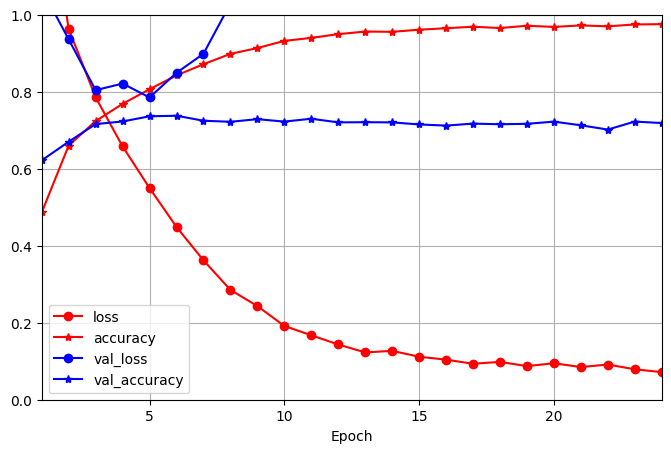

In [15]:
plot_learning_curves(history)

In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 2.0986 - accuracy: 0.7047


[2.0985910892486572, 0.7046999931335449]

In [55]:
predictions = model.predict(X_test, verbose=0)
predicted_all = [np.argmax(x) for x in predictions]

In [56]:
incorrect = [X_test[idx] for idx, x in enumerate(predicted_all) if x != y_test[idx]]
predicted = [predicted_all[idx] for idx, x in enumerate(predicted_all) if x != y_test[idx]]
expected = [y_test[idx] for idx, x in enumerate(predicted_all) if x != y_test[idx]]

incorrect = np.array(incorrect)
predicted = np.array(predicted).reshape(-1, 1)
expected = np.array(expected)

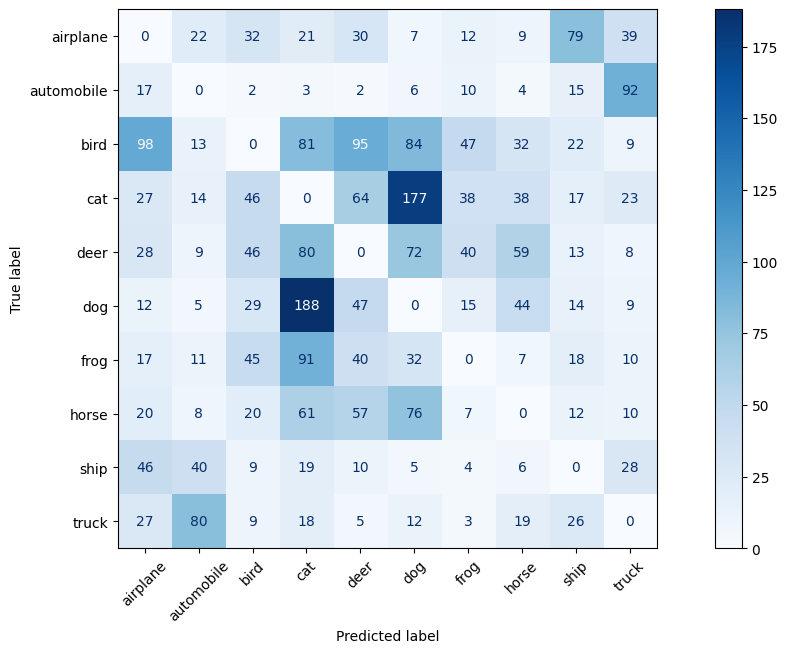

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
cm = confusion_matrix(expected, predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues')
ax.xaxis.set_ticklabels(class_names, rotation=45)
plt.show()

In [59]:
def plot_figures(X, y, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols*row + col
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(X[index])
            plt.title(class_names[y[index,0]])
            plt.axis('off')

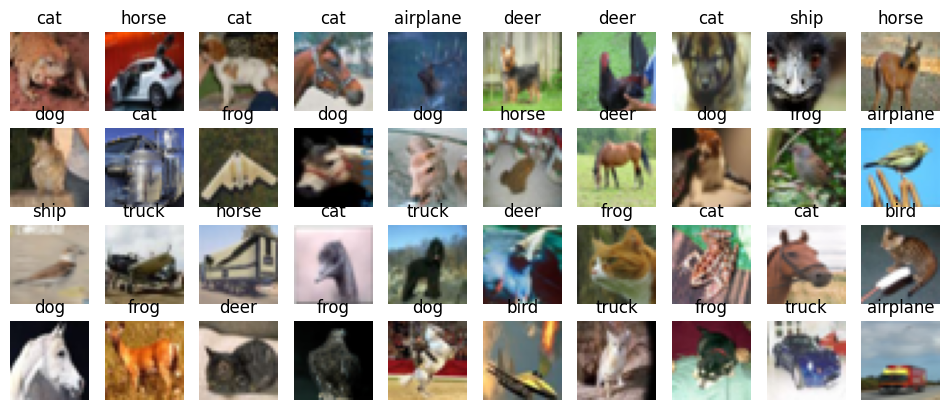

In [60]:
plot_figures(incorrect, predicted, n_rows=4, n_cols=10)